# Time Series Analysis - Solar Power Generation
Análise de série temporal utilizando Rede Neural Recorrente (técnica Long Short-Term Memory). Objetivos:
 - Melhoria da precisão do modelo de previsão
 - Comparação da precisão do modelo quando treinado com dados com diferentes granularidades (diária e semanal)
 - Verificação da capacidade de um modelo treinado em uma granalaridade menor (semanal) na previsão de valores em uma granularidade maior do dados (mensal, anual)

#### Dataset
Geração de energia solar em países europeus em 30 anos (1986-2015), dados coletados por hora.

link: https://www.kaggle.com/sohier/30-years-of-european-solar-generation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


In [2]:
# ===== Funções para Manipulação da base de dados ===== #
def data_by_days(dataset, n_days):
    # Realiza transformação nos dados, agrupando-os por uma determinada quantidade de dias
    #(dados originais coletados por hora)
    data = []
    for day in range(0, len(dataset), 24*n_days):
        data.append(sum(dataset[day : day+(n_days*24-1)]))
    data = pd.Series(data)
    
    return data

def group_data_by_days(dataset, n_period):
    # Realiza transformação nos dados, agrupando-os por uma determinada quantidade de dias
    # Função utilizada na comparação das granularidades
    data = []
    for period in range(0, len(dataset), n_period):
        data.append(sum(dataset[period : period+(n_period-1)]))
    data = np.array(data)
    
    return data.reshape(-1,)

def split_dataset(data, test_size, validation_size=None):
    # Divide o dataset para treinamento, teste e validação
    # ou somente treinamento e teste caso o validation_size não seja passado
    if validation_size is None or validation_size < 1:
        data_train = data[:-test_size]
        data_test = data[-(test_size+n_prev):]
        data_validation = None
    else:
        data_train = data[:-(test_size+validation_size)]
        data_test = data[-(test_size+validation_size+n_prev):-validation_size]
        data_validation = data[-validation_size:]
    
    return data_train, data_test, data_validation

def create_previsores(n_previsores, dataset):
    # Cria os atributos previsores em uma sequência cronológica (n-n_previsores até n) para cada registro
    previsores = []
    
    for i in range(n_previsores, len(dataset)):
        previsores.append(dataset[i-n_previsores : i])
    previsores = np.array(previsores)
    target = np.array(dataset[n_previsores:])
    
    return previsores, target

In [3]:
# ===== Funções para Salvar e Carregar Modelo ===== #
def save_model_structure(model, file_name):
    model_json = model.to_json()
    with open('{}.json'.format(file_name), 'w') as json_file:
        json_file.write(model_json)

def load_model(file_name):
    file = open('{}.json'.format(file_name), 'r')
    model_json = file.read()
    file.close()
    
    model = model_from_json(model_json)
    model.load_weights('{}.h5'.format(file_name))
    
    return model

In [4]:
# ===== Funções para Visualização dos Resultados ===== #
def plot_results(real_value, predicted_value, title):
    # Compara os valores previstos com a base de dados de teste
    plt.figure(figsize=(10,7))    
    plt.plot(real_value, color='blue', label='Valor Real')
    plt.plot(predicted_value, color='red', label='Previsões')
    plt.title(title)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Power (MW)')
    plt.show()

def make_prediction(all_data, modelo, n_periods, n_previsores):
    # Realiza a previsão de valores futuros pelos próximos n_periods
    previsoes = np.empty(shape=(1,))
    previsoes = np.delete(previsoes, 0)
    
    # seleciona a quantidade necessária de previsores para realizar a previsão
    #previsores = all_data[:-n_days_validate]
    #previsores = previsores[-n_previsores:]
    previsores = all_data[-n_previsores:]
    previsores = np.reshape(previsores, (1,-1,1))
    
    # cada previsão no tempo t passa a ser utilizada como atributo previsor para a próxima previsão no tempo t+1
    for time in range(n_periods):
        previsao = modelo.predict(previsores)
        
        previsores = np.delete(previsores, 0, axis=1) # deleta o atributo previsor mais antigo
        previsores = np.insert(previsores, previsores.shape[1], values=previsao, axis=1) # adiciona o atributo previsor recém previsto
        
        previsoes = np.insert(previsoes, previsoes.shape[0], values=previsao)
    
    return previsoes # all values are scaled

### Exploração da Base de Dados

In [5]:
base= pd.read_csv('solar_power.csv')
countries = ['Austria', 'Belgium', 'Bulgaria', 'Switzerland', 'Cyprus', 'CzechRep', 
             'Germany', 'Denmark', 'Estonia', 'Spain', 'Finland', 'France',
             'Greece', 'Croatia', 'Hungary', 'Ireland', 'Italy', 'Lithuania', 
             'Luxemburg', 'Latvia', 'Netherlands', 'Norway', 'Poland', 'Portugal',
             'Romania', 'Slovenia', 'Slovakia', 'Sweden', 'UnitedKingdom']
base.columns = countries

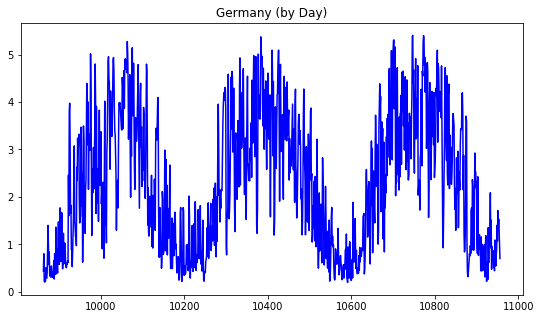

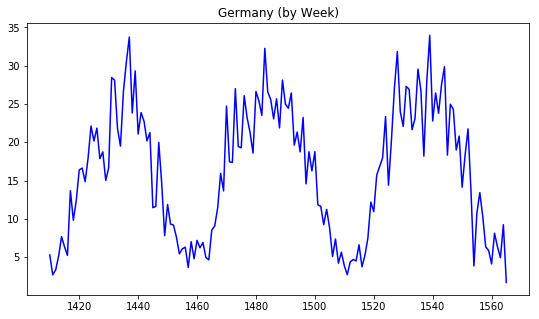

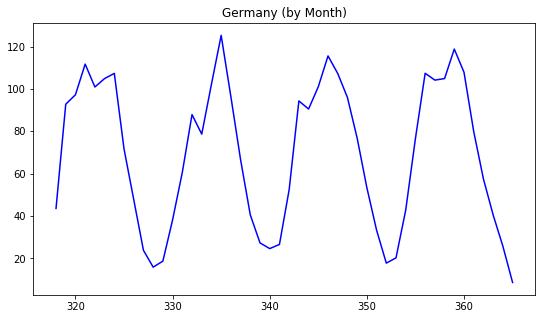

In [8]:
def plot_data(by, amount_years, data):
    if by == 'day':
        unit = 365
    elif by == 'week':
        unit = 52
    elif by == 'month':
        unit = 12
    
    plt.figure(figsize=(9,5))
    plt.plot(data[-unit*amount_years:], color='blue')
    plt.title('Germany (by {})'.format(by.capitalize()))
    plt.show()

plot_data(by='day', amount_years=3, data=data_by_days(base['Germany'], n_days=1))
plot_data(by='week', amount_years=3, data=data_by_days(base['Germany'], n_days=7))
plot_data(by='month', amount_years=4, data=data_by_days(base['Germany'], n_days=30))

<br/><br/><br/>
## Previsão com Granularidade Diária - Germany

In [6]:
n_prev = 90 # usa dados dos 90 dias anteriores para prever próximo dia
n_days_test = 60 # 60 dias para teste
n_days_validate = 365 # últimos 365 dias para validação

In [7]:
germany_1d = data_by_days(base['Germany'], n_days=1)

scaler = MinMaxScaler(feature_range=(0,1))
germany_1scaled = scaler.fit_transform(germany_1d.values.reshape(-1,1))

In [8]:
# ===== Divisão entre dados de Treino, Teste e Validação ===== #
base_train, base_test, base_validate = split_dataset(germany_1scaled, test_size=n_days_test, validation_size=n_days_validate)

prev_train, target_train = create_previsores(n_prev, base_train)
prev_test, target_test = create_previsores(n_prev, base_test)
prev_validate, target_validate = create_previsores(n_prev, base_validate)

prev_train = prev_train.reshape((prev_train.shape[0],prev_train.shape[1], 1))
prev_test = prev_test.reshape((prev_test.shape[0],prev_test.shape[1], 1))

#### Criação do Modelo de Previsão

In [9]:
model_germany_day = Sequential()
model_germany_day.add(LSTM(units=60, activation='tanh', return_sequences=True, input_shape=(n_prev, 1)))
model_germany_day.add(LSTM(units=60, activation='tanh', return_sequences=True))
model_germany_day.add(LSTM(units=60, activation='tanh'))
model_germany_day.add(Dense(units=1, activation='linear'))
model_germany_day.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

early_stop = EarlyStopping(monitor='loss', min_delta=1e-10, patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='loss', min_delta=1e-3, factor=0.5, patience=5, min_lr=1e-8, verbose=1)
model_save = ModelCheckpoint('solar_byDay_Germany_01.h5', monitor='loss', save_best_only=True, verbose=1)

# Foram realizados testes com diferentes parâmetros:
 # activation: ['relu', 'tanh']
 # optimizer: ['adam', 'rmsprop']
 # layers: [3, 4]
 # batch_size, epochs, n_previsores, camada de dropout

In [12]:
save_model_structure(model_germany_day, file_name='solar_byDay_Germany_01')

#### Treino e Teste do Modelo

In [11]:
model_germany_day.fit(prev_train, target_train, batch_size=12, epochs=150, callbacks=[early_stop, reduce_lr, model_save])

Epoch 1/150
10442/10442 [==============================] - 57s 5ms/step - loss: 0.0262 - mean_absolute_error: 0.1285

Epoch 00001: loss improved from inf to 0.02623, saving model to solar_byDay_Germany_01.h5
Epoch 2/150
10442/10442 [==============================] - 59s 6ms/step - loss: 0.0203 - mean_absolute_error: 0.1120

Epoch 00002: loss improved from 0.02623 to 0.02025, saving model to solar_byDay_Germany_01.h5
Epoch 3/150
10442/10442 [==============================] - 59s 6ms/step - loss: 0.0203 - mean_absolute_error: 0.1121

Epoch 00003: loss did not improve from 0.02025
Epoch 4/150
10442/10442 [==============================] - 59s 6ms/step - loss: 0.0199 - mean_absolute_error: 0.1104

Epoch 00004: loss improved from 0.02025 to 0.01991, saving model to solar_byDay_Germany_01.h5
Epoch 5/150
10442/10442 [==============================] - 59s 6ms/step - loss: 0.0198 - mean_absolute_error: 0.1101

Epoch 00005: loss improved from 0.01991 to 0.01976, saving model to solar_byDay_Germa

10442/10442 [==============================] - 60s 6ms/step - loss: 0.0185 - mean_absolute_error: 0.1069

Epoch 00041: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00041: loss did not improve from 0.01852
Epoch 42/150
10442/10442 [==============================] - 60s 6ms/step - loss: 0.0185 - mean_absolute_error: 0.1068

Epoch 00042: loss improved from 0.01852 to 0.01851, saving model to solar_byDay_Germany_01.h5
Epoch 43/150
10442/10442 [==============================] - 60s 6ms/step - loss: 0.0185 - mean_absolute_error: 0.1069

Epoch 00043: loss improved from 0.01851 to 0.01851, saving model to solar_byDay_Germany_01.h5
Epoch 44/150
10442/10442 [==============================] - 59s 6ms/step - loss: 0.0185 - mean_absolute_error: 0.1067

Epoch 00044: loss improved from 0.01851 to 0.01851, saving model to solar_byDay_Germany_01.h5
Epoch 45/150
10442/10442 [==============================] - 59s 6ms/step - loss: 0.0185 - mean_absolute_error: 0.1068

Epoch 00

10442/10442 [==============================] - 60s 6ms/step - loss: 0.0185 - mean_absolute_error: 0.1068

Epoch 00121: loss did not improve from 0.01849
Epoch 122/150
10442/10442 [==============================] - 60s 6ms/step - loss: 0.0185 - mean_absolute_error: 0.1068

Epoch 00122: loss improved from 0.01849 to 0.01849, saving model to solar_byDay_Germany_01.h5
Epoch 123/150
10442/10442 [==============================] - 58s 6ms/step - loss: 0.0185 - mean_absolute_error: 0.1068

Epoch 00123: loss did not improve from 0.01849
Epoch 124/150
10442/10442 [==============================] - 58s 6ms/step - loss: 0.0185 - mean_absolute_error: 0.1068

Epoch 00124: loss improved from 0.01849 to 0.01849, saving model to solar_byDay_Germany_01.h5
Epoch 125/150
10442/10442 [==============================] - 57s 6ms/step - loss: 0.0185 - mean_absolute_error: 0.1068

Epoch 00125: loss improved from 0.01849 to 0.01849, saving model to solar_byDay_Germany_01.h5
Epoch 126/150
10442/10442 [===========

In [9]:
model_germany_day = load_model(file_name='solar_byDay_Germany_01')

In [10]:
previsoes = model_germany_day.predict(prev_test)

#### Avaliação dos Resultados de Teste

In [11]:
target_test_unscaled = scaler.inverse_transform(target_test)
previsoes_unscaled = scaler.inverse_transform(previsoes)

error_test = mean_absolute_error(target_test_unscaled, previsoes_unscaled)
error_test

0.2877810137259667

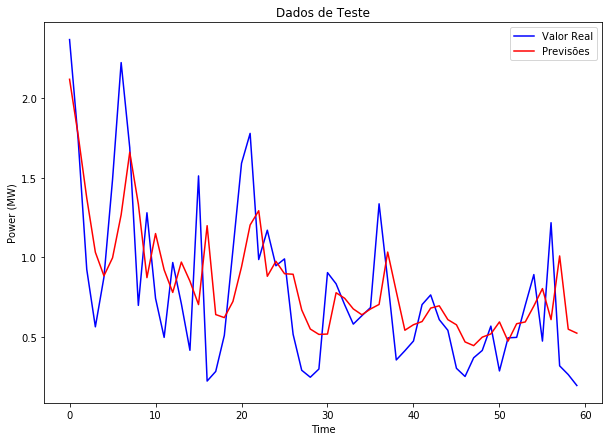

In [215]:
    # ===== Visualização Gráfica dos Resultados de Teste ===== #
plot_results(target_test_unscaled, previsoes_unscaled, title='Dados de Teste')

#### Avaliação dos Resultados dos Dados de Validação

In [12]:
future = make_prediction(germany_1scaled[:-n_days_validate], model_germany_day, n_periods=n_days_validate, n_previsores = n_prev)
future_day_unscaled = scaler.inverse_transform(future.reshape(-1, 1))

In [13]:
base_validate_day_unscaled = scaler.inverse_transform(base_validate)
error_validate = mean_absolute_error(base_validate_day_unscaled, future_day_unscaled)
error_validate

0.8749048480595526

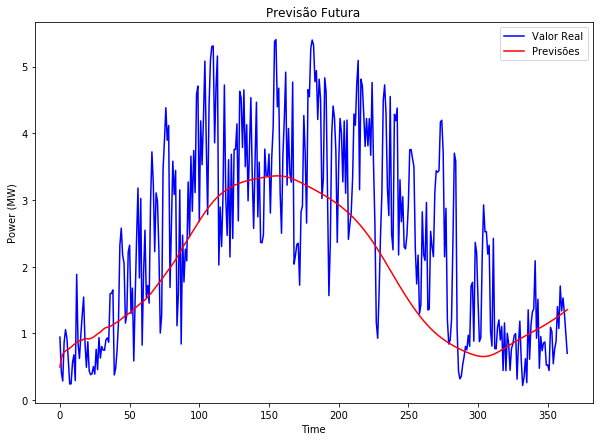

In [94]:
    # ===== Visualização Gráfica dos Resultados de Predição Futura ===== #
plot_results(list(base_validate_day_unscaled), future_day_unscaled, title='Previsão Futura')

O modelo consegue captar a tendência dos dados ao longo do tempo. Contudo, como era de se esperar, não consegue captar as grandes variações que acontecem em um curto período de tempo.

<br/><br/><br/>
## Previsão com Granularidade Semanal - Germany

In [19]:
n_prev = 52 # usa dados das 52 semanas anteriores para prever próximo semana
n_days_test = 52 # 52 semanas para teste
n_days_validate = 52 # últimas 52 semanas para validação

In [20]:
germany_7d = data_by_days(base['Germany'], n_days=7)

scaler = MinMaxScaler(feature_range=(0,1))
germany_7scaled = scaler.fit_transform(germany_7d.values.reshape(-1,1))

In [21]:
# ===== Divisão entre dados de Treino, Teste e Validação ===== #
base_train, base_test, base_validate = split_dataset(germany_7scaled, test_size=n_days_test, validation_size=n_days_validate)

prev_train, target_train = create_previsores(n_prev, base_train)
prev_test, target_test = create_previsores(n_prev, base_test)
prev_validate, target_validate = create_previsores(n_prev, base_validate)

prev_train = prev_train.reshape((prev_train.shape[0],prev_train.shape[1], 1))
prev_test = prev_test.reshape((prev_test.shape[0],prev_test.shape[1], 1))

#### Criação do Modelo de Previsão

In [58]:
model_germany_week = Sequential()
model_germany_week.add(LSTM(units=60, activation='tanh', return_sequences=True, input_shape=(n_prev, 1)))
model_germany_week.add(LSTM(units=60, activation='tanh', return_sequences=True))
model_germany_week.add(LSTM(units=60, activation='tanh'))
model_germany_week.add(Dense(units=1, activation='linear'))
model_germany_week.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

early_stop = EarlyStopping(monitor='loss', min_delta=1e-10, patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='loss', min_delta=1e-3, factor=0.5, patience=5, min_lr=1e-8, verbose=1)
model_save = ModelCheckpoint('solar_byWeek_Germany_01.h5', monitor='loss', save_best_only=True, verbose=1)

In [59]:
save_model_structure(model_germany_week, file_name='solar_byWeek_Germany_01')

In [95]:
model_germany_week.fit(prev_train, target_train, batch_size=12, epochs=150, callbacks=[early_stop, reduce_lr, model_save])

Epoch 1/150
1410/1410 [==============================] - 5s 3ms/step - loss: 0.0382 - mean_absolute_error: 0.1480

Epoch 00001: loss improved from inf to 0.03816, saving model to solar_byWeek_Germany_01.h5
Epoch 2/150
1410/1410 [==============================] - 4s 3ms/step - loss: 0.0176 - mean_absolute_error: 0.1052

Epoch 00002: loss improved from 0.03816 to 0.01763, saving model to solar_byWeek_Germany_01.h5
Epoch 3/150
1410/1410 [==============================] - 4s 3ms/step - loss: 0.0173 - mean_absolute_error: 0.1021

Epoch 00003: loss improved from 0.01763 to 0.01726, saving model to solar_byWeek_Germany_01.h5
Epoch 4/150
1410/1410 [==============================] - 4s 3ms/step - loss: 0.0168 - mean_absolute_error: 0.1019

Epoch 00004: loss improved from 0.01726 to 0.01684, saving model to solar_byWeek_Germany_01.h5
Epoch 5/150
1410/1410 [==============================] - 4s 3ms/step - loss: 0.0164 - mean_absolute_error: 0.0986

Epoch 00005: loss improved from 0.01684 to 0.0163

1410/1410 [==============================] - 4s 3ms/step - loss: 0.0135 - mean_absolute_error: 0.0905

Epoch 00043: loss improved from 0.01352 to 0.01351, saving model to solar_byWeek_Germany_01.h5
Epoch 44/150
1410/1410 [==============================] - 4s 3ms/step - loss: 0.0135 - mean_absolute_error: 0.0903

Epoch 00044: loss improved from 0.01351 to 0.01350, saving model to solar_byWeek_Germany_01.h5
Epoch 45/150
1410/1410 [==============================] - 4s 3ms/step - loss: 0.0135 - mean_absolute_error: 0.0904

Epoch 00045: loss improved from 0.01350 to 0.01350, saving model to solar_byWeek_Germany_01.h5
Epoch 46/150
1410/1410 [==============================] - 4s 3ms/step - loss: 0.0135 - mean_absolute_error: 0.0904

Epoch 00046: loss did not improve from 0.01350
Epoch 47/150
1410/1410 [==============================] - 4s 3ms/step - loss: 0.0135 - mean_absolute_error: 0.0903

Epoch 00047: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00047: loss di

1410/1410 [==============================] - 4s 3ms/step - loss: 0.0135 - mean_absolute_error: 0.0903

Epoch 00084: loss did not improve from 0.01347
Epoch 85/150
1410/1410 [==============================] - 4s 3ms/step - loss: 0.0135 - mean_absolute_error: 0.0903

Epoch 00085: loss improved from 0.01347 to 0.01347, saving model to solar_byWeek_Germany_01.h5
Epoch 86/150
1410/1410 [==============================] - 4s 3ms/step - loss: 0.0135 - mean_absolute_error: 0.0903

Epoch 00086: loss improved from 0.01347 to 0.01347, saving model to solar_byWeek_Germany_01.h5
Epoch 87/150
1410/1410 [==============================] - 4s 3ms/step - loss: 0.0135 - mean_absolute_error: 0.0903

Epoch 00087: ReduceLROnPlateau reducing learning rate to 1.525878978725359e-08.

Epoch 00087: loss did not improve from 0.01347
Epoch 88/150
1410/1410 [==============================] - 4s 3ms/step - loss: 0.0135 - mean_absolute_error: 0.0903

Epoch 00088: loss improved from 0.01347 to 0.01347, saving model to 

In [22]:
model_germany_week = load_model(file_name='solar_byWeek_Germany_01')

In [23]:
previsoes = model_germany_week.predict(prev_test)

#### Avaliação dos Resultados de Teste

In [24]:
target_test_unscaled = scaler.inverse_transform(target_test)
previsoes_unscaled = scaler.inverse_transform(previsoes)

error_test = mean_absolute_error(target_test_unscaled, previsoes_unscaled)
error_test

2.198852879481229

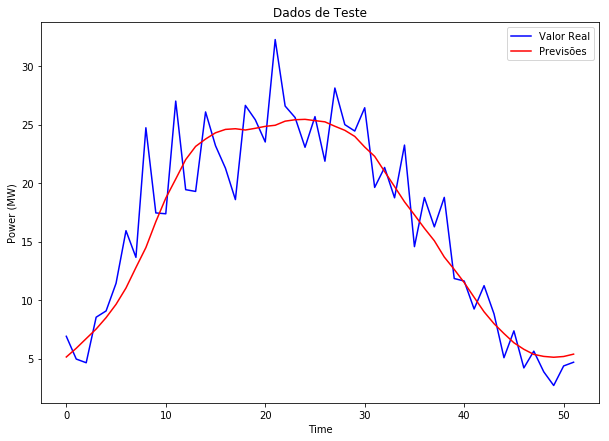

In [104]:
    # ===== Visualização Gráfica dos Resultados de Teste ===== #
plot_results(target_test_unscaled, previsoes_unscaled, title='Dados de Teste')

#### Avaliação dos Resultados dos Dados de Validação

In [25]:
future = make_prediction(germany_7scaled[:-n_days_validate], model_germany_week, n_periods=n_days_validate, n_previsores = n_prev)
future_week_unscaled = scaler.inverse_transform(future.reshape(-1, 1))

In [26]:
base_validate_week_unscaled = scaler.inverse_transform(base_validate)
error_validate = mean_absolute_error(base_validate_week_unscaled, future_week_unscaled)
error_validate

2.882610819065307

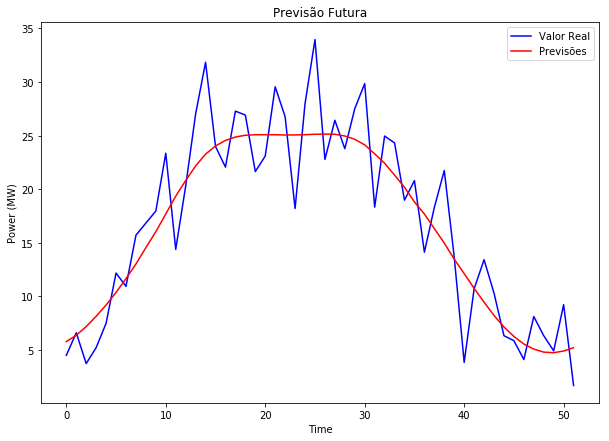

In [107]:
    # ===== Visualização Gráfica dos Resultados de Predição Futura ===== #
plot_results(list(base_validate_week_unscaled), future_week_unscaled, title='Previsão Futura')

Embora o modelo não consiga se adaptar aos picos, ele capta bem a tendência dos dados ao longo do tempo. Em comparação a granularidade diária, os dados semanais apresentam uma variação menor (com menos "ruído"), o que parece permitir uma previsão mais confiável/precisa.

<br/><br/><br/>
## Comparação Granularidade Diária x Semanal - Germany
Os erros médios obtidos (2.198853 e 2.882611 para o treino e validação respectivamente) são maiores que aqueles obtidos para a granularidade diária (0.287781 e 0.882611 para o treino e validação respectivamente). Porém, isso se dá por conta da escala dos dados.

É preciso, portanto, utilizar alguma forma de avaliar corretamente a diferença de precisão entre as duas granularidades utilizadas.

#### Comparação de Erro no Somatório Anual de Geração de Energia

In [22]:
base_validate_day_unscaled_yearsum = group_data_by_days(base_validate_day_unscaled, n_period=365)[0]
future_day_unscaled_yearsum = group_data_by_days(future_day_unscaled, n_period=365)[0]

base_validate_week_unscaled_yearsum = group_data_by_days(base_validate_week_unscaled, n_period=52)[0]
future_week_unscaled_yearsum = group_data_by_days(future_week_unscaled, n_period=52)[0]

          Gran. Diária  Gran. Semanal
Original    893.805572     888.331235
Previsão    686.302318     851.308830
Erro        207.503255      37.022405


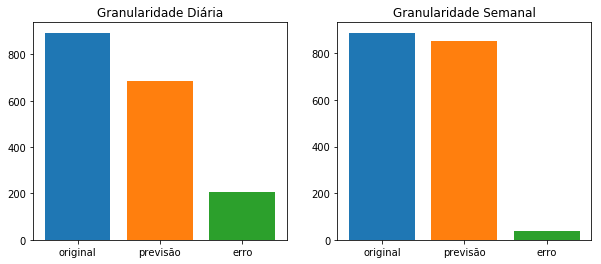

In [207]:
df_data = {'Gran. Diária' : (base_validate_day_unscaled_yearsum, future_day_unscaled_yearsum, 
                             base_validate_day_unscaled_yearsum-future_day_unscaled_yearsum),
          'Gran. Semanal' : (base_validate_week_unscaled_yearsum, future_week_unscaled_yearsum, 
                             base_validate_week_unscaled_yearsum-future_week_unscaled_yearsum)}
print(pd.DataFrame(df_data, index=['Original', 'Previsão', 'Erro']))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar('original', base_validate_day_unscaled_yearsum)
plt.bar('previsão', future_day_unscaled_yearsum)
plt.bar('erro', base_validate_day_unscaled_yearsum-future_day_unscaled_yearsum)
plt.title('Granularidade Diária')

plt.subplot(1,2,2)
plt.bar('original', base_validate_week_unscaled_yearsum)
plt.bar('previsão', future_week_unscaled_yearsum)
plt.bar('erro', base_validate_week_unscaled_yearsum-future_week_unscaled_yearsum)
plt.title('Granularidade Semanal')

plt.show()

**Obs.:** A diferença entre os valores originais nas duas granularidades (893.8 e 888.3) se dá, pois no período de 1 ano utilizado, foram considerados 365 dias (granularidade diária) e 52 semanas (granularidade semanal). Mas essa diferença não é relevante considerando a grande diferença entre os erros obtidos nas duas granularidade.

#### Comparação Estatística das Distribuições

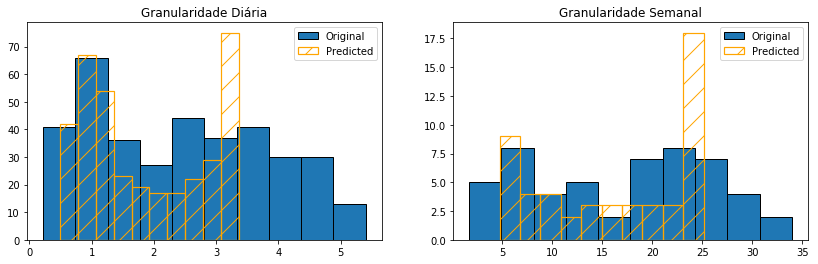

In [175]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.hist(base_validate_day_unscaled, bins=10, edgecolor='black', linewidth=1, fill=True, label='Original')
plt.hist(future_day_unscaled, bins=10, hatch='/', edgecolor='orange', linewidth=1.2, fill=False, label='Predicted')
plt.legend()
plt.title('Granularidade Diária')

plt.subplot(1,2,2)
plt.hist(base_validate_week_unscaled, bins=10, edgecolor='black', linewidth=1, fill=True, label='Original')
plt.hist(future_week_unscaled, bins=10, hatch='/', edgecolor='orange', linewidth=1.2, fill=False, label='Predicted')
plt.legend()
plt.title('Granularidade Semanal')
plt.show()

In [192]:
print('Granularidade Diária')
df_data = {'Original' : (base_validate_day_unscaled.mean(), base_validate_day_unscaled.std(ddof=1)),
          'Previsão' : (future_day_unscaled.mean(), future_day_unscaled.std(ddof=1))}
print(pd.DataFrame(df_data, index=['mean', 'stdDev']))

print('\nGranularidade Semanal')
df_data = {'Original' : (base_validate_week_unscaled.mean(), base_validate_week_unscaled.std(ddof=1)),
          'Previsão' : (future_week_unscaled.mean(), future_week_unscaled.std(ddof=1))}
print(pd.DataFrame(df_data, index=['mean', 'stdDev']))

Granularidade Diária
        Original  Previsão
mean     2.45070  1.883992
stdDev   1.43562  0.972895

Granularidade Semanal
         Original   Previsão
mean    17.115708  16.471541
stdDev   8.903803   7.699234


In [174]:
print('Granularidade Diária')
t = (future_day_unscaled.mean() - base_validate_day_unscaled.mean())/(future_day_unscaled.std(ddof=1)/np.sqrt(future_day_unscaled.shape[0]))
print(' t-value: {} & df: {}'.format(round(t, 6), 364))
print(' p < 0.0001')

print('\nGranularidade Semanal')
t = (future_week_unscaled.mean() - base_validate_week_unscaled.mean())/(future_week_unscaled.std(ddof=1)/np.sqrt(future_week_unscaled.shape[0]))
print(' t-value: {} & df: {}'.format(round(t, 6), 51))
print(' p = 0.5489')

# obs: Link utilizado para cálculo: https://www.graphpad.com/quickcalcs/pValue1/

Granularidade Diária
 t-value: -11.128589 & df: 364
 p < 0.0001

Granularidade Semanal
 t-value: -0.603327 & df: 51
 p = 0.5489


A fim de comparar estatísticamente os dados obtidos, assume-se 2 distribuições normais genéricas com características de média e desvio padrão semelhantes aos dados em análise.

Dessa forma, sabendo que o baixo valor de *p*, indica uma significante diferença estatística entre dois conjuntos de dados, e vice-versa, pode-se concluir que utilizando a granularidade semanal é possível realizar previsões mais confiáveis e precisas, já que, estatísticamente, os dados de validação e os valores previsto com essa granularidade são bem mais parecidos. 

Abaixo, é possível visualizar graficamente a diferença entre 2 distribuições normais genéricas com características de média e desvio padrão semelhantes aos dados analisados.

In [194]:
x_orig_1d = np.random.normal(loc=base_validate_day_unscaled.mean(), scale=base_validate_day_unscaled.std(ddof=1), size=2000)
x_pred_1d = np.random.normal(loc=future_day_unscaled.mean(), scale=future_day_unscaled.std(ddof=1), size=2000)

In [201]:
x_orig_7d = np.random.normal(loc=base_validate_week_unscaled.mean(), scale=base_validate_week_unscaled.std(ddof=1), size=2000)
x_pred_7d = np.random.normal(loc=future_week_unscaled.mean(), scale=future_week_unscaled.std(ddof=1), size=2000)

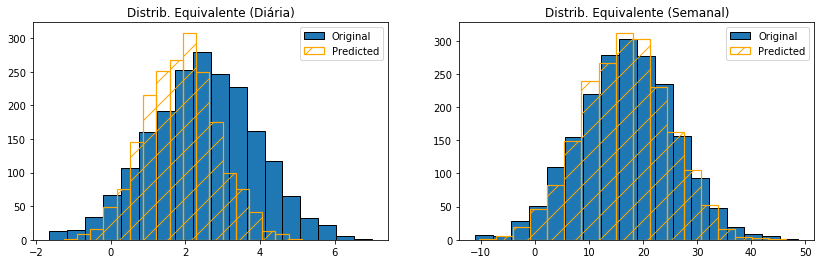

In [208]:
n_bins = 18

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.hist(x_orig_1d, bins=n_bins, edgecolor='black', linewidth=1, fill=True, label='Original')
plt.hist(x_pred_1d, bins=n_bins, hatch='/', edgecolor='orange', linewidth=1.2, fill=False, label='Predicted')
plt.legend()
plt.title('Distrib. Equivalente (Diária)')

plt.subplot(1,2,2)
plt.hist(x_orig_7d, bins=n_bins, edgecolor='black', linewidth=1, fill=True, label='Original')
plt.hist(x_pred_7d, bins=n_bins, hatch='/', edgecolor='orange', linewidth=1.2, fill=False, label='Predicted')
plt.legend()
plt.title('Distrib. Equivalente (Semanal)')
plt.show()

<br/><br/><br/>
## Previsão de Tendência a Longo Prazo

In [53]:
range_anos = list(range(1986, 2015+1))
n_weeks = 52*5

In [54]:
further_future = make_prediction(germany_7scaled[:-n_days_validate], model_germany_week, n_periods=n_weeks, n_previsores = n_prev)
further_future_week_unscaled = scaler.inverse_transform(further_future.reshape(-1, 1))

#### Previsão Mensal

In [55]:
further_future_week_unscaled_monthsum = group_data_by_days(further_future_week_unscaled, n_period=4)

In [56]:
germany_1m = group_data_by_days(germany_7d[len(germany_7d)%4:], n_period=4)

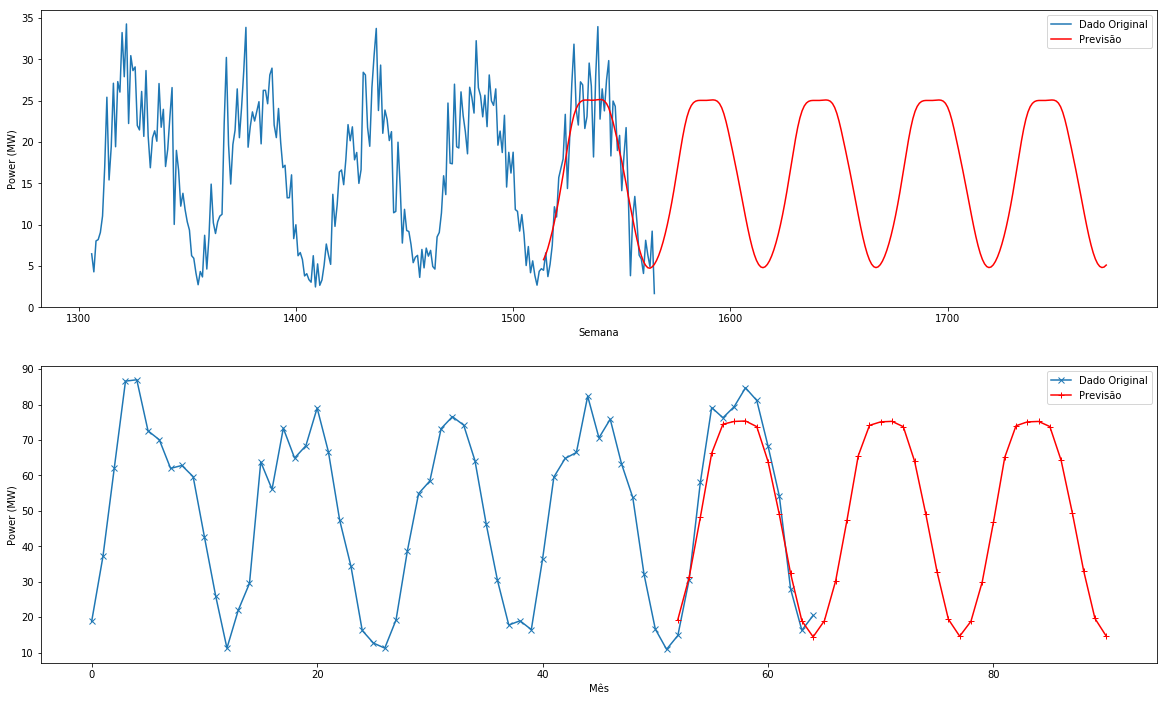

In [99]:
plt.figure(figsize=(20,12))
plt.subplot(2,1,1)
plt.plot(germany_7d[-5*52:], label='Dado Original' )
plt.plot(list(range(len(germany_7d)-52, len(germany_7d)-52+n_weeks)), further_future_week_unscaled, 
         color='red', label='Previsão')
plt.xlabel('Semana')
plt.ylabel('Power (MW)')
plt.legend()

plt.subplot(2,1,2)
plt.plot(germany_1m[-5*13:], label='Dado Original', marker='x')
plt.plot(list(range(len(germany_1m[-5*13:])-13, len(germany_1m[-5*13:])-13+len(further_future_week_unscaled_monthsum[:-2*13]))), 
         further_future_week_unscaled_monthsum[:-2*13], 
         color='red', label='Previsão', marker='+')
plt.xlabel('Mês')
plt.ylabel('Power (MW)')
plt.legend()

plt.show()

In [96]:
print('Valor no ano 2015:')
pd.DataFrame([germany_1m[-13:], further_future_week_unscaled_monthsum[:13]], index=['Real', 'Previsto'],
                  columns=list(map(lambda x: 'Mês {}'.format(x+1), list(range(13)))))

Valor no ano 2015:


,Mês 1,Mês 2,Mês 3,Mês 4,Mês 5,Mês 6,Mês 7,Mês 8,Mês 9,Mês 10,Mês 11,Mês 12,Mês 13
Real,14.832635,30.608015,58.156616,79.155736,76.267572,79.413377,84.723907,81.151606,68.265857,54.175834,27.972213,16.308587,20.478312
Previsto,19.345366,31.225229,48.276347,66.257403,74.459124,75.233063,75.361715,73.764741,63.925983,48.986672,32.340494,18.956482,14.449310


In [97]:
print('Média ao longo dos meses de 2015:')
print(' Real:     {:.6f}'.format(germany_1m.mean()))
print(' Prevista: {:.6f}'.format(further_future_week_unscaled_monthsum.mean()))

Média ao longo dos meses de 2015:
 Real:     49.239534
 Prevista: 49.262082


**Obs.:** É considerado um ano de 13 meses. Pois, por questão de simplificação, considera-se cada mês ter 4 semanas, o que faz com que seja necessário 13 meses para completar 52 semanas

#### Previsão Anual

In [65]:
further_future_week_unscaled_yearsum = group_data_by_days(further_future_week_unscaled, n_period=52)

In [66]:
germany_1y = group_data_by_days(germany_7d[len(germany_7d)%52:], n_period=52)

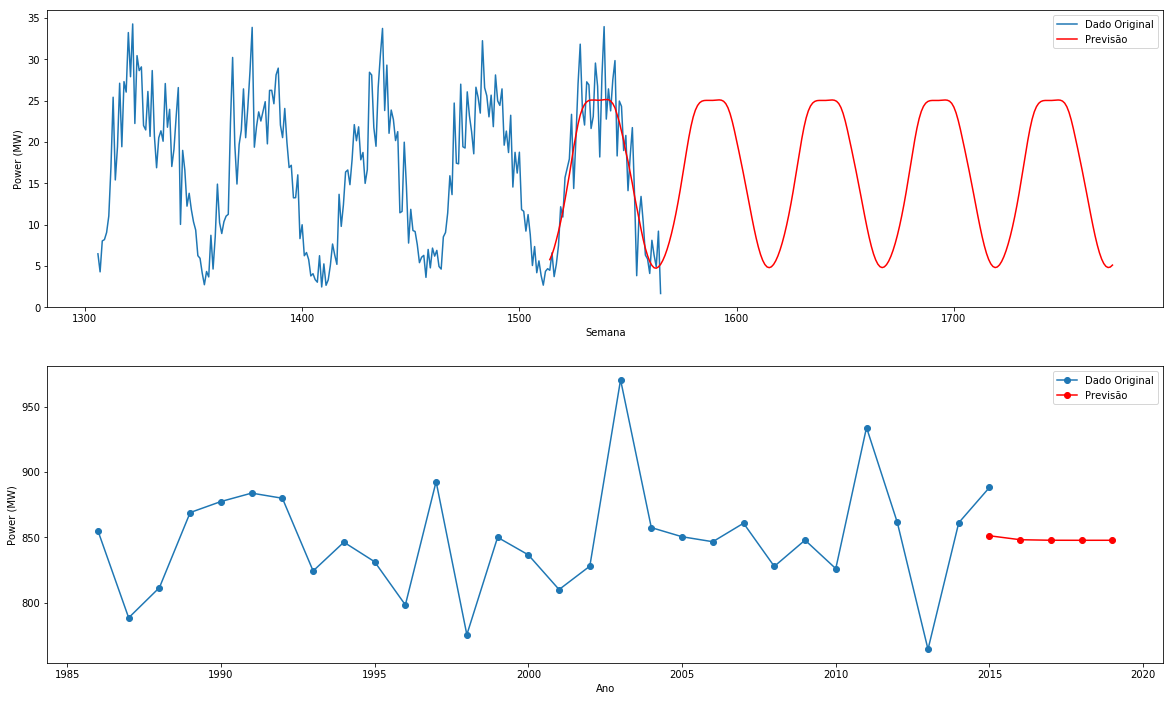

In [68]:
plt.figure(figsize=(20,12))
plt.subplot(2,1,1)
plt.plot(germany_7d[-5*52:], label='Dado Original' )
plt.plot(list(range(len(germany_7d)-52, len(germany_7d)-52+n_weeks)), further_future_week_unscaled, 
         color='red', label='Previsão')
plt.xlabel('Semana')
plt.ylabel('Power (MW)')
plt.legend()

plt.subplot(2,1,2)
plt.plot(range_anos, germany_1y, label='Dado Original', marker='o')
plt.plot(list(range(range_anos[len(range_anos)-1], range_anos[len(range_anos)-1]+5)), further_future_week_unscaled_yearsum, 
         color='red', label='Previsão', marker='o')
plt.xlabel('Ano')
plt.ylabel('Power (MW)')
plt.legend()

plt.show()

In [69]:
print('Valor no ano 2015:')
print(' Valor Real: {:.6f}'.format(germany_1y[len(germany_1y)-1]))
print(' Previsto:   {:.6f}'.format(further_future_week_unscaled_yearsum[0]))

Valor no ano 2015:
 Valor Real: 888.331235
 Previsto:   851.308830


In [70]:
print('Media ao longo dos anos:')
print(' Real:     {:.6f}'.format(germany_1y.mean()))
print(' Prevista: {:.6f}'.format(further_future_week_unscaled_yearsum.mean()))

Media ao longo dos anos:
 Real:     848.606474
 Prevista: 848.637114


O modelo se comporta bem quando analisado na granularidade em que foi treinado (semanal), e também ao aumentar a granularidade para mensal, sendo capaz de enxergar a tendência cíclica em ambas as granularidades. Porém, ao aumentar a granularidade para anual, ele tem a tendência a acomodar no valor médio.